# Base Line Method

This Jupyter notebook contains the implementation of the baseline method. It uses the 3 original csv files and 'labelled_sample_tweets.csv' as input and creates 'BaseLineApproach_Final_tweets.csv'
Import the datasets and combine the datasets into a single dataframe

In [1]:
# Import the necessary library
import pandas as pd

# Load the datasets again
kejriwal_data = pd.read_csv("../Datasets/Arvind Kejriwal_data.csv")
modi_data = pd.read_csv("../Datasets/Narendra Modi_data.csv")
gandhi_data = pd.read_csv("../Datasets/Rahul Gandhi_data.csv")

# Combine the datasets into a single dataframe
combined_data = pd.concat([kejriwal_data, modi_data, gandhi_data], ignore_index=True)

# Display the first few rows of the combined dataset to verify
combined_data.head()


,Date,User,Tweet,Time
0,2022:10:19,bhoo_sene,@TajinderBagga Aap leaders are speaking agains...,23:47:01
1,2022:10:19,Madhusu88858324,Bjp Aap se sikh rhi h\nNarendra Modi Manish Si...,23:06:35
2,2022:10:19,PremshilaKumarp,@JaikyYadav16 Arvind kejriwal,22:56:42
3,2022:10:19,lifebecom,Arvind Kejriwal As PM Visits Gujarat School ht...,22:20:51
4,2022:10:19,sphavisha,Arvind Kejriwal's stand against rape is very c...,22:20:16


### Cleaning

In [2]:

# Define the cleaning function to retain exclamatory marks (!) and question marks (?)
def clean_tweet_retain_special(tweet):
    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    # Remove user mentions (@)
    tweet = re.sub(r'\@\w+', '', tweet)
    tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', tweet)
    tweet = re.sub(r'\^[a-zA-Z]\s+', ' ', tweet) 
    tweet = re.sub(r'\s+', ' ', tweet, flags=re.I)
    tweet = re.sub(r'^b\s+', '', tweet)
    # Convert to lowercase for uniformity (but note that this won't impact non-Latin scripts)
    tweet = tweet.lower()
    return tweet


In [3]:
import re

# Clean the tweets in the dataset without removing exclamatory marks and question marks
combined_data['Cleaned_Tweet'] = combined_data['Tweet'].apply(clean_tweet_retain_special)

# Remove duplicates based on the cleaned tweets
combined_data.drop_duplicates(subset=['Cleaned_Tweet'], keep='first', inplace=True)

# Display the first few rows after cleaning
combined_data[['Tweet', 'Cleaned_Tweet']].head()

,Tweet,Cleaned_Tweet
0,@TajinderBagga Aap leaders are speaking agains...,aap leaders are speaking against hindu gods. ...
1,Bjp Aap se sikh rhi h\nNarendra Modi Manish Si...,bjp aap se sikh rhi narendra modi manish sisod...
2,@JaikyYadav16 Arvind kejriwal,arvind kejriwal
3,Arvind Kejriwal As PM Visits Gujarat School ht...,arvind kejriwal as pm visits gujarat school
4,Arvind Kejriwal's stand against rape is very c...,arvind kejriwal's stand against rape is very c...


In [4]:
import nltk
import matplotlib.pyplot as plt
from collections import Counter

# Tokenization using space-based split
combined_data['Tokens'] = combined_data['Cleaned_Tweet'].str.split()

In [5]:
import ast

# 1. Load the data into a dataframe
BaseLineApproach_Final_tweets =  pd.read_csv('../Temp/labelled_sample_tweets.csv')

# Convert the string representation of list to an actual list
BaseLineApproach_Final_tweets['Tokens'] = BaseLineApproach_Final_tweets['Tokens'].apply(ast.literal_eval)

# 2. Remove matching tweets from combined_data
filtered_combined_data = combined_data[~combined_data['Tweet'].isin(BaseLineApproach_Final_tweets['Tweet'])]

# Check the shape of the updated combined_data dataframe
filtered_combined_data.shape


(171770, 6)

In [6]:
BaseLineApproach_Final_tweets.head()

,Date,User,Tweet,Time,Cleaned_Tweet,Tokens,Manual_Label
0,2022:08:10,tsg_sportsgrail,AAP MLA Saurabh Bhardwaj Lies About Divya Kakr...,9:02:30,aap mla saurabh bhardwaj lies about divya kakr...,"[AAP, MLA, Saurabh, Bhardwaj, Lies, About, Div...",Neutral
1,2022:10:10,TIMES18News,RJD President Lalu Prasad Tejashwi Yadav Pitch...,12:52:39,rjd president lalu prasad tejashwi yadav pitch...,"[RJD, President, Lalu, Prasad, Tejashwi, Yadav...",Neutral
2,2022:09:21,HUNTDAILYNEWS1,French President Emmanuel Macron said Indian P...,4:28:54,french president emmanuel macron said indian p...,"[French, President, Emmanuel, Macron, said, In...",Negative
3,2022:07:12,tfipost,The appointment of Raghav Chadha as a secret C...,9:30:00,the appointment of raghav chadha as secret chi...,"[The, appointment, of, Raghav, Chadha, as, a, ...",Neutral
4,2022:08:27,Man_u_man,@thatmarineguy21 @ArvindKejriwal Arvind kejriw...,13:52:23,arvind kejriwal will not answer but he will q...,"[@thatmarineguy21, @ArvindKejriwal, Arvind, ke...",Negative


### Vectorization

1. further clean the unwanted characters in the tweets
2. Apply Tokenization to the tweets
3. train the FastText model, we will get the vector for each token in the data

In [7]:
from gensim.models import FastText
import re
def extended_cleaning(text):
    # Remove unwanted characters
    text = re.sub(r'--|-|&|gt|;|#|\||\?', ' ', text)
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply the extended cleaning
BaseLineApproach_Final_tweets['Enhanced_Cleaned_Tweet'] = BaseLineApproach_Final_tweets['Cleaned_Tweet'].apply(extended_cleaning)

# Tokenize the enhanced cleaned tweets
tokenized_tweets = BaseLineApproach_Final_tweets['Enhanced_Cleaned_Tweet'].apply(nltk.word_tokenize)

# Train the FastText model
model = FastText(sentences=tokenized_tweets, vector_size=100, window=5, min_count=5, workers=4)

# Now, for each word in our vocabulary, we can get its vector representation
# For example, to get the vector for the word 'politics':
print(model.wv['modi'])
print(len(model.wv['modi']))


[-1.6737800e-03 -1.6334209e-04 -1.0607428e-03 -7.1109453e-04
  5.1046680e-03  3.7176069e-04 -5.1890127e-04  1.3070498e-03
  6.4595853e-04 -1.9713523e-04 -2.5431504e-03  6.5337954e-04
  2.7899095e-03  2.7588897e-03 -1.6142211e-03  1.6122329e-04
 -3.0041390e-04  4.6447185e-05  2.1444692e-03 -1.1812277e-03
 -2.6238279e-03 -2.5478839e-03  1.1665034e-03 -1.8224716e-03
  7.3897303e-04  2.6965039e-04  2.9206870e-04  1.5701848e-03
  1.5052111e-03 -5.2851328e-04  1.7235978e-04 -1.3156532e-04
  9.4163197e-04 -3.6704793e-04 -7.9250993e-04 -1.2271575e-03
  2.4588064e-03 -1.7028752e-03 -3.4969111e-04 -1.4649958e-03
  3.7300616e-04  2.2935090e-03  1.4525955e-03  9.6184906e-04
  1.0134100e-03 -4.1673006e-04 -2.9901310e-03  1.0952280e-03
 -2.0914124e-03 -2.3866745e-03  7.4333051e-04 -1.4371086e-03
 -3.1893598e-03 -2.4329582e-03 -3.4574969e-05 -1.7562107e-03
  1.0646955e-03 -1.0118615e-03 -2.9390918e-03 -5.9648685e-04
  1.3953060e-03  8.6427765e-04 -2.9732872e-04  2.0459525e-03
  1.4061946e-04  6.01696

Lets visualize the vectors

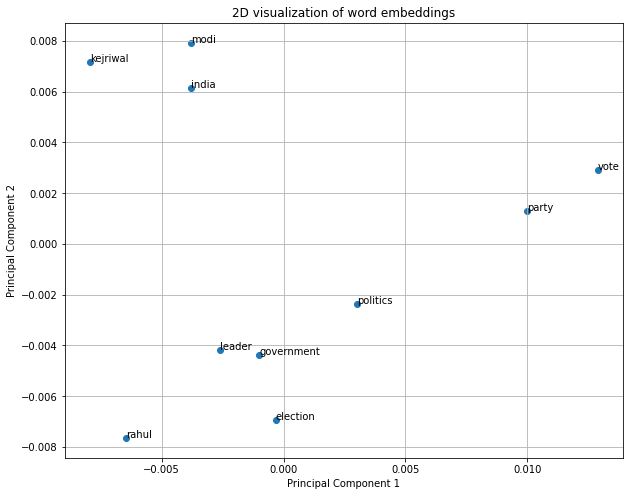

In [8]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Extract word vectors for a selected list of words (you can customize this list)
words = ['modi', 'kejriwal', 'rahul', 'india', 'politics', 'leader', 'party', 'election', 'vote', 'government']
word_vectors = [model.wv[word] for word in words]

# Apply PCA to reduce dimensions to 2
pca = PCA(n_components=2)
result = pca.fit_transform(word_vectors)

# Create the scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))

plt.title("2D visualization of word embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()


### SentiWordNet

Lets first load the sentiwordnet files into the system

In [9]:
import pandas as pd
from nltk.corpus import sentiwordnet as swn

# Load Hindi SentiWordNet
hindi_swn = pd.read_csv('../SentiWordNet/HSWN_WN.txt', sep=' ', header=None)
hindi_pos = set(hindi_swn[hindi_swn[2] > hindi_swn[3]][4])
hindi_neg = set(hindi_swn[hindi_swn[2] < hindi_swn[3]][4])
hindi_neu = set(hindi_swn[hindi_swn[2] == hindi_swn[3]][4])
hindi_pos_list = [word for sublist in hindi_pos for word in sublist.split(',')]
hindi_neg_list = [word for sublist in hindi_neg for word in sublist.split(',')]
hindi_neu_list = [word for sublist in hindi_neu for word in sublist.split(',')]

# Load Telugu SentiWordNet
telugu_pos = set(pd.read_csv('../SentiWordNet/TE_POS.txt', sep='\t', header=None)[1])
telugu_neg = set(pd.read_csv('../SentiWordNet/TE_NEG.txt', sep='\t', header=None)[1])
telugu_neu = set(pd.read_csv('../SentiWordNet/TE_NEU.txt', sep='\t', header=None)[1])

# For English SentiWordNet, you can use NLTK's in-built SentiWordNet


### Testing

Lets first see how it works

In [10]:
def get_sentiment(word, lang):
    if lang == 'en':
        # For simplicity, using TextBlob for English
        from textblob import TextBlob
        polarity = TextBlob(word).sentiment.polarity
        if polarity > 0:
            return 'Positive'
        elif polarity < 0:
            return 'Negative'
        else:
            return 'Neutral'
    
    elif lang == 'hi':
        # Lookup in Hindi SentiWordNet
        if word in hindi_pos_list:
            return 'Positive'
        elif word in hindi_neg_list:
            return 'Negative'
        elif word in hindi_neu_list:
            return 'Neutral'
        else:
            return 'Unknown'
    
    elif lang == 'te':
        # Lookup in Telugu SentiWordNet
        if word in telugu_pos:
            return 'Positive'
        elif word in telugu_neg:
            return 'Negative'
        elif word in telugu_neu:
            return 'Neutral'
        else:
            return 'Unknown'
    
    else:
        return 'Unknown'

In [12]:
# Sample words from each language
sample_words = {
    'English': ['happy', 'sad', 'neutral'],
    'Hindi': ['खुश', 'दुःखी', 'आज'], 
    'Telugu': ['సంతోషంగా', 'దుఃఖము', 'ప్లీనరీ'] 
}
# Fetch sentiment for each word
sentiments = {
    'English': [get_sentiment(word, 'en') for word in sample_words['English']],
    'Hindi': [get_sentiment(word, 'hi') for word in sample_words['Hindi']],
    'Telugu': [get_sentiment(word, 'te') for word in sample_words['Telugu']]
}

# Convert to DataFrame for display
df_sample_words = pd.DataFrame({
    'Language': ['English']*3 + ['Hindi']*3 + ['Telugu']*3,
    'Word': sample_words['English'] + sample_words['Hindi'] + sample_words['Telugu'],
    'Sentiment': sentiments['English'] + sentiments['Hindi'] + sentiments['Telugu']
})

df_sample_words


,Language,Word,Sentiment
0,English,happy,Positive
1,English,sad,Negative
2,English,neutral,Neutral
3,Hindi,खुश,Positive
4,Hindi,दुःखी,Negative
5,Hindi,आज,Neutral
6,Telugu,సంతోషంగా,Positive
7,Telugu,దుఃఖము,Negative
8,Telugu,ప్లీనరీ,Neutral


In [13]:
get_sentiment('खुश', 'hi')

'Positive'

### Sentiment Score Calculation

Lets create a function that will calculate the sentiment score for each word

In [14]:
def calculate_sentiment_score(tweet_tokens):
    score = 0
    for word in tweet_tokens:
        # Check for word in Hindi SentiWordNet
        if word in hindi_pos_list:
            score += 1
        elif word in hindi_neg_list:
            score -= 1
        # Check for word in Telugu SentiWordNet
        elif word in telugu_pos:
            score += 1
        elif word in telugu_neg:
            score -= 1
        # Check for word in English SentiWordNet (this can be expanded)
        else:
            # Assuming the word is an adjective for simplicity;
            pos_types = ['n', 'v', 'a', 'r']
            for pos in pos_types:
                senti_synsets = list(swn.senti_synsets(word, pos))
                if senti_synsets:
                    score += senti_synsets[0].pos_score() - senti_synsets[0].neg_score()
    return score

In [15]:
# Calculate sentiment score for the 97th tweet
calculate_sentiment_score(BaseLineApproach_Final_tweets.iloc[97]['Tokens'])

0.875

Apply it to all the Tweets to get the sentiment scores

In [16]:
# Calculate sentiment scores for all tweets
BaseLineApproach_Final_tweets['Sentiment_Score'] = BaseLineApproach_Final_tweets['Tokens'].apply(calculate_sentiment_score)

In [17]:
pd.set_option('display.max_colwidth', None)
BaseLineApproach_Final_tweets[['Tokens','Sentiment_Score']].tail()

,Tokens,Sentiment_Score
95,"[మోదీ, బర్త్‌, డే.., పుట్టినరోజు, పిల్లలకు, బంగారం, గిఫ్ట్.., |, ABN, Digital, Watch, Video, ---&gt;&gt;, https://t.co/oMx11Dnmjd, #Narendra_Modi, #NarendraModiJiBirthday, #BJPLeaders, #goldsupply, #TamilNadu, #ABN, #ABNDigital]",-0.750
96,"[BJP, అబ్బద్దప్రచారాలను, పటాపంచలు, చేస్తూ, దూసుకుపోతున్న, రాహుల్, గాంధీ, ఇమేజ్.., Rahul, Gandhi, #RahulGandhiVoiceOfIndia, #BharatJodoYatra, https://t.co/jbzW3DCsOa]",0.000
97,"[@narendramodi, నేడు, Prime, Minister, of, India, Narendra, Modi, గారి, జన్మదిన, వేడుకలు, సందర్భంగా, శుభాకాంక్షలు, తెలుపుతూ, శ్రీ, సత్య, సాయి, జిల్లా, కదిరి, నియోజక, వర్గం, నంబుల, పూలకుంట, ప్రాధమిక, వైద్యశాల, నందు, రక్త, దానం, చేయడం, జరిగింది., https://t.co/v5ZQGd1J3T]",0.875
98,"[మోదీ, కాన్వాయ్, లోకి, ఆంబులెన్స్, –, కాసేపు, కాన్వాయ్, ని, పక్కకు, నిలిపిన, ప్రధాని, సిబ్బంది-సోషల్మీడియోలో, వీడియో, వైరల్, |, Narendra, Modi, |, Gujarat, |, Ambulance, |, MyIndMedia, #Gujarat, #NarendraModi, #Modi, #BJP, #Ambulance, https://t.co/SpDA6xVzYY]",0.000
99,"[బీజేపీ, ప్రభుత్వం, ఎలా, ఏర్పడుతున్నాయి?, BJP, |, Narendra, Modi, |, Sitharam, Yec..., https://t.co/vjXs4a79tr, via, @YouTube]",0.000


### Sentiment Classification

Lets classify the sentimets based on the score that we got.

In [18]:
def classify_sentiment(score):
    if score > 0:
        return "Positive"
    elif score < 0:
        return "Negative"
    else:
        return "Neutral"

BaseLineApproach_Final_tweets['Sentiment'] = BaseLineApproach_Final_tweets['Sentiment_Score'].apply(classify_sentiment)

In [19]:
BaseLineApproach_Final_tweets[['Sentiment_Score','Sentiment']].tail()

,Sentiment_Score,Sentiment
95,-0.750,Negative
96,0.000,Neutral
97,0.875,Positive
98,0.000,Neutral
99,0.000,Neutral


Lets plot all the sentiment scores that we got

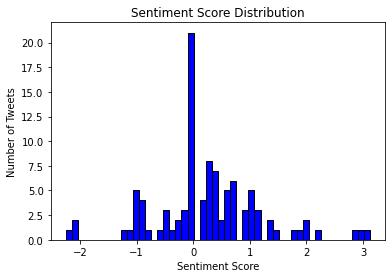

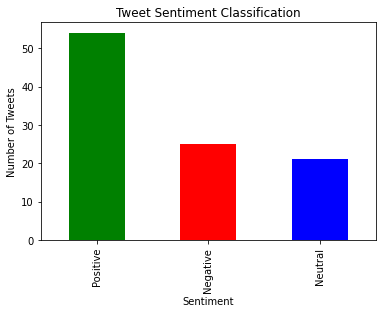

In [20]:
import matplotlib.pyplot as plt

# Sentiment Score Distribution
plt.hist(BaseLineApproach_Final_tweets['Sentiment_Score'], bins=50, color='blue', edgecolor='black')
plt.title('Sentiment Score Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Tweets')
plt.show()

# Tweet Sentiment Classification
BaseLineApproach_Final_tweets['Sentiment'].value_counts().plot(kind='bar', color=['green', 'red', 'blue'])
plt.title('Tweet Sentiment Classification')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.show()

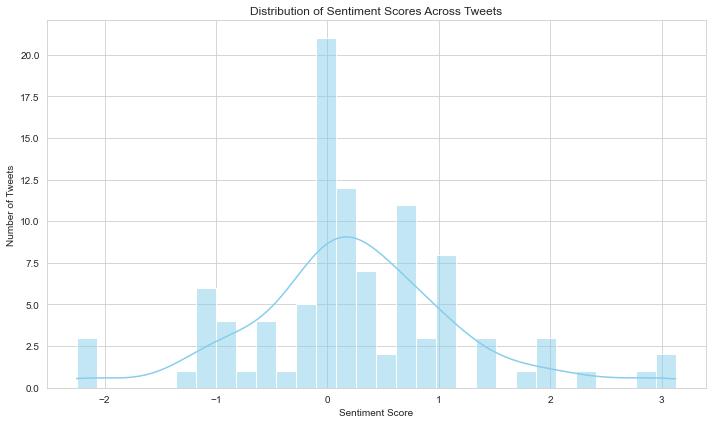

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of Seaborn for better visualization
sns.set_style("whitegrid")

# Plotting the histogram
plt.figure(figsize=(10, 6))
sns.histplot(BaseLineApproach_Final_tweets['Sentiment_Score'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Sentiment Scores Across Tweets')
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Tweets')
plt.tight_layout()
plt.show()



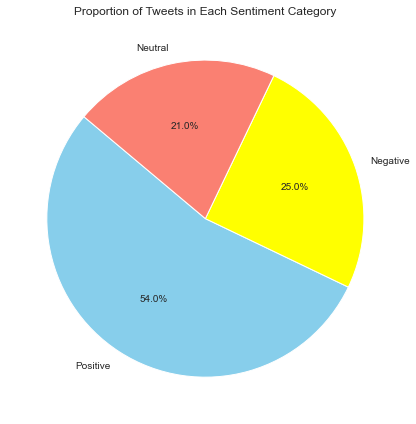

In [22]:
# Calculate the count of each sentiment category
sentiment_counts = BaseLineApproach_Final_tweets['Sentiment'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(8, 6))
sentiment_counts.plot.pie(autopct='%1.1f%%', startangle=140, colors=['skyblue', 'yellow', 'salmon'])
plt.title('Proportion of Tweets in Each Sentiment Category')
plt.ylabel('')  # Hide y-label as it's not needed for pie charts
plt.tight_layout()
plt.show()


In [23]:
BaseLineApproach_Final_tweets['Sentiment'].value_counts()

Positive    54
Negative    25
Neutral     21
Name: Sentiment, dtype: int64

# Writing the final_sample_tweets dataframe to a CSV file

In [24]:
# Writing the final_sample_tweets dataframe to a CSV file
file_path = "../Temp/BaseLineApproach_Final_tweets.csv"
BaseLineApproach_Final_tweets.to_csv(file_path, index=False)